# Preface
> The questions/exercises given for the assignment has been repeated in this notebook, they have been put in bold. To easily distinguish our answers and explanations have been indented, or printed from the executed code. 

## Imports
> The following imports are needed throughout the notebook:

In [24]:
import csv
import os
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import re
import string
import statistics
import numpy as np
import random
import math
import pandas as pd
import json
import urllib.request
import powerlaw

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from community import community_louvain
from collections import Counter
from os import listdir
from bs4 import BeautifulSoup

## Data

> The downloaded files can be found in the folders `dc` and `marvel`, in our [github project](https://github.com/pete414n/02805SG/tree/main/assignment2).

In [17]:
G = nx.read_gml("superhero.edgelist")

# Basic Stats

**Write a short paragraph describing the network. The paragraph should contain the following information**
- **The number of nodes and links.**

In [18]:
# Number of nodes
num_nodes = len(G.nodes())
print(f"Number of nodes = {num_nodes}")

# Number of links
num_links = len(G.edges()) # Assuming we get an edge list
print(f"Number of links = {num_links}")

Number of nodes = 1650
Number of links = 19072


- **The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.**

In [19]:
# Making a sorted list of the in degrees and a list of the out degrees
in_degree_list = sorted([d for (c, d) in G.in_degree], reverse=True)
out_degree_list = sorted([d for (c, d) in G.out_degree], reverse=True)

# Average in degree
sum = 0
for d in in_degree_list:
  sum += d
print(f"average in degree = {sum / len(in_degree_list)}")

# Average out degree
sum = 0
for d in out_degree_list:
  sum += d
print(f"average out degree = {sum / len(out_degree_list)}")

average in degree = 11.558787878787879
average out degree = 11.558787878787879


In [20]:
# Median in degree
median = -1
mid = len(in_degree_list) // 2
if len(in_degree_list) % 2 == 0:
  median = (in_degree_list[mid] + in_degree_list[mid+1]) / 2
else:
  median = in_degree_list[mid]
print(f"median in degree = {median}")

# Median out degree
median = -1
mid = len(in_degree_list) // 2
if len(in_degree_list) % 2 == 0:
  median = (in_degree_list[mid] + in_degree_list[mid+1]) / 2
else:
  median = in_degree_list[mid]
print(f"median out degree = {median}")

median in degree = 5.0
median out degree = 5.0


In [21]:
# Mode in degree
mode = max(set(in_degree_list), key=in_degree_list.count)
print(f"mode in degree = {mode}")

# Mode out degree
mode = max(set(in_degree_list), key=in_degree_list.count)
print(f"mode out degree = {mode}")

mode in degree = 0
mode out degree = 0


In [22]:
# Since we have the sorted list, the first element will be the max and the last will be the min
# Minimum and maximum in degree
min_in_degree = in_degree_list[-1]
max_in_degree = in_degree_list[0]
print(f"minimum in degree = {min_in_degree}\nmaximum in degree = {max_in_degree}\n")

# Minimum and maximum out degree
min_out_degree = out_degree_list[-1]
max_out_degree = out_degree_list[0]
print(f"minimum out degree = {min_out_degree}\nmaximum out degree = {max_out_degree}\n")

minimum in degree = 0
maximum in degree = 429

minimum out degree = 0
maximum out degree = 68



> This is just a placeholder for the short paragraph

**We also want the degree distributions and a plot of the network**
- **Create in- and out-going degree distributions as described in Lecture 5.**

In [25]:
# 
alpha_in = powerlaw.Fit(in_degree_list)
alpha_out = powerlaw.Fit(out_degree_list)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


- **Estimate the slope of the incoming degree distribtion as described in Lecture 5.**

- **Plot the network using the Force Atlas algorithm as described in Lecture 5.**

# Communities

**Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.**

> We will be focusing on the DC superhefore universe. We start by recreating our graph for just the DC characters:

In [27]:
# Recreating the network H, for only the dc universe
dc_files = os.listdir('dc')
H = nx.DiGraph()

dc_nodes = []
marvel_nodes = []

# For week 5 we are adding the lengths of the wikitext for each character
for dc_char in dc_files:
  H.add_node(dc_char[:-4], uni="dc", length=0)

# Adding all the dc nodes and edges
for source in dc_files:
  # Remove .txt ending for character name
  name = source[0:len(source)-4]

  # Get the wikitext saved for this character
  with open('dc/' + source) as f:
    lines = f.read()

  # Find all the links in this wikitext
  matches = re.findall(r'[[]{2}.*?[]]{2}', lines)

  # Count the number of words in this wikitext and set that attribute
  word_count = len(re.findall(r'\w+', lines))
  H.nodes[name]['length'] = word_count

  # Construct possible file name:
  links = []
  for match in matches: 
    link = match[2:len(match)-2]
    link = link.split("|")[0]
    link = re.sub(r'\s', '_', link) 
    #link.replace("ñ", "n")
    link.replace("/", "-")
    links.append(link)

  # Remove duplicates
  links = [*set(links)]

  # Add an edge for each link that can be found in either fold
  for link in links:
    if os.path.isfile('dc/' + link + ".txt") or os.path.isfile('marvel/' + link + ".txt"):
      H.add_edge(name, link)

largest_cc = max(nx.weakly_connected_components(H), key=len)
gcc = nx.subgraph(H, largest_cc)
uH = gcc.to_undirected(reciprocal=False, as_view=True)

In [30]:
# Example from: https://perso.crans.org/aynaud/communities/
#first compute the best partition
partition = community_louvain.best_partition(uH)


partition
# Some code to find the number of communities and the number of nodes in each, needed for next question

{'Abby_Holland': 0,
 'Abin_Sur': 1,
 'Abra_Kadabra_(character)': 2,
 'Ace_the_Bat-Hound': 6,
 'Adam_Strange': 4,
 'Agent_Liberty': 5,
 'Air_Wave': 1,
 'Albert_Rothstein': 0,
 'Alura_(DC_Comics)': 5,
 'Amazing-Man_(DC_Comics)': 5,
 'Amazo': 4,
 'Ambush_Bug': 6,
 'Amethyst,_Princess_of_Gemworld': 0,
 'Amygdala_(comics)': 6,
 'Anarky': 6,
 'Angel_and_the_Ape': 2,
 'Animal-Vegetable-Mineral_Man': 7,
 'Animal_Man': 4,
 'Anna_Fortune': 0,
 'Anthro_(comics)': 8,
 'Anti-Monitor': 1,
 'Antiope_(character)': 9,
 'Anton_Arcane': 0,
 'Apache_Chief': 9,
 'Aquagirl': 7,
 'Aqualad': 8,
 'Aquaman': 4,
 'Arak_(character)': 10,
 'Ares_(DC_Comics)': 9,
 'Argent_(character)': 7,
 'Arion_(character)': 4,
 'Arisia_Rrab': 1,
 'Arrowette': 9,
 'Artemis_of_Bana-Mighdall': 9,
 'Atom_(character)': 1,
 'Atomic_Knight': 2,
 'Atomic_Skull': 4,
 'Atrocitus': 1,
 'Axis_Amerika#Members': 9,
 'Azrael_(DC_Comics)': 6,
 'Aztek_(character)': 4,
 "B'wana_Beast": 4,
 'Bane_(DC_Comics)': 6,
 'Baron_Bedlam': 2,
 'Baron_Blitzk

**Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.**

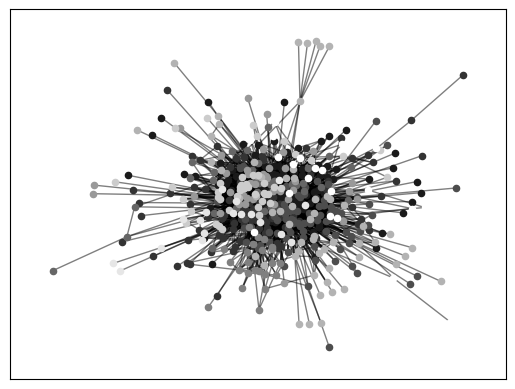

In [29]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(uH)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(uH, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(uH,pos, alpha=0.5)

# Needs coloring for the communities and smaller node size(?) or something else to make it more readable

plt.show()

**Write a paragraph about your work to identify the communities. The paragraph should include**
- **Information about the algorithm you used to find communities.**
- **The value of modularity for your network.**
- **The number of communities and their sizes (in terms of number of nodes).**

> This is just a placeholder for the paragraph. Something about the Louvain algorithm. Something about modularity. Something about the number of communities and their sizes.

**For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.**

> This is just a placeholder for the paragraph explaining how TF-IDF works

**Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.**

> This is just a placeholder for the paragraph for our answer and the justification

# Sentiment

**First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.**

> We start by preparing the data from the files that have been given for the exercise. First we make a list of all the words from the given sentiment list with their associated average happiness score:

In [31]:
# Create an empty list to store tuples of words and their 
# average happiness score
sent_list = []

# Read in the .tsv file
with open("dataset_s1.tsv", "r", encoding="utf8") as sent_file:
    tsv_reader = csv.DictReader(sent_file, delimiter="\t")
    # For each sentiment in the file, save the word and average happiness in a tuple
    # and add it to the list
    for sent in tsv_reader:
        word = sent["word"]
        average = sent["happiness_average"]
        sent_list.append((word, average))

> Then we create a function to calculate the sentiment from a frequency distribution for a given file:

In [32]:
# Function for calculating the sentiment of a file from the frequency distribution for that file
def sentiment(tokens):
    # Total sentiment score of file
    sent_sum = 0.0
    # Total number of occurences of words
    occ_sum = 0
    
    # For each token and associated number of occurences
    for token, occ in tokens.items():
        # If the token is in the given list of words with rated happiness
        if token in [i[0] for i in sent_list]:
            # For the token and score in the list of words with rated happiness
            for (token, score) in sent_list:
                # Multiply the average happiness score with the number of occurences
                sent_sum += (float(score) * occ)
                # Add the number of occurences to the total number of occurences
                occ_sum += occ
    return sent_sum / occ_sum

> Then we create lists of the

> We are now ready to calculate the mean, 10th percentile, and the 90th percentile:

In [15]:
#Source: https://stackoverflow.com/questions/2374640/how-do-i-calculate-percentiles-with-python-numpy

# mean
mean_total = np.mean() # Insert data

# 10th percentile
per_10th = np.percentile(, 10) # Insert data

# 90 percentile sentiment 
per_90th =  np.percentile(, 90) # Insert data

SyntaxError: invalid syntax (591039494.py, line 7)

> We are now able to make the histogram with the distribution and the calculated values:

In [ ]:
result = plt.hist(, bins=20, color='c', edgecolor='k', alpha=0.65) # Insert data set
plt.axvline(per_10th, color='blue', linestyle='dashed', linewidth=1, label="10th percentile")
plt.axvline(per_90th, color='green', linestyle='dashed', linewidth=1, label="90th percentile")
plt.axvline(mean_total, color='orange', linestyle='dashed', linewidth=1, label="mean")
plt.xlabel('sentiment')
plt.ylabel('counts')
plt.figtext(.5,-0.05, f"Histogram displaying the distribution of sentiments for all of the characters from the Marvel and DC universes. The dashed blue line is the 10th percentile, the dashed green line is the 90th percentile, and the dashed orange line is the mean.", ha='center')
plt.legend()
plt.show()

**Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.**

> We start by creating lists of the good and the bad guys:

In [ ]:
# Read in the given file
with open('wiki_meta_data.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

# Initialize lists to hold the names of the good and bad guys
good_guys = []
bad_guys = []
characters = []
alignments = []
  
# For each character in the given file
for info in data:
    # If the character is good
    if info[6] == '1':
        # Add that character name to the list of good guys
        good_guys.append(info[1])
        
        alignments.append(info[6])
    # If the character is bad
    if info[7] == '0':
        # Add that character name to the list of bad guys
        bad_guys.append(info[1])
        # Add the current alignment for that index in the alignment list
        alignments.append(info[7])
    # Add the character name to the full list of characters    
    characters.append(info[1])

# Remove the first element of the list since this contains the titles of the columns from the file
characters = characters[1:]
        
#### NOTE: Remember to remove the bad/good guys that have been removed from the graph 

> We can now go through our graph and grab the previously calculated sentiments for each node, and add it to a list of either sentiments for good or bad guys:

In [ ]:
# For each node in the graph, take out the character name and the sentiment value
all_nodes = [(k,v) for k,v in nx.get_node_attributes(G, "sent").items()]

# Init lists to hold sentiment values for good guys (gg) and bad guys (bg)
gg_sent = []
bg_sent = []

# For each tuple consisting of a character name (node) and a sentiment value in the all_nodes list
for node, sent in all_nodes:
    # If the character is one of the good guys
    if node in good_guys:
        # Add its sentiment value to the list of sentiments for good guys
        gg_sent.append(sent)
    # If the character is one of the bad guys
    if node in bad_guys:
        # Add its sentiment value to the list of the sentiments for the bad guys
        bg_sent.append(sent)

> The mean, 10th and 90th percentiles can now be calculated for both good and bad guys, and plotted in histograms:

In [ ]:
# Histogram for good and bad guys
gg_counts, gg_bins = np.histogram(gg_sent)
bg_counts, bg_bins = np.histogram(bg_sent)

# Setting same number of bins for both
number_of_bins = 10 

# Create two subplots and unpack the output array immediately
fig, axs = plt.subplots(1, 2, sharex=True)

# Histogram for good guys
histogram = np.histogram(gg_sent, number_of_bins)

# Calculate values
mean_gg = np.mean() # Insert data
per_10th_gg = np.percentile(, 10) # Insert data
per_90th_gg =  np.percentile(, 90) # Insert data

axs[0].hist(gg_sent, bins = 25, edgecolor='black')
axs[0].set_title(f'Histogram of good guys sentiment')
axs[0].xlabel('sentiment')
axs[0].ylabel('counts')
axs[0].axvline(per_10th_gg, color='blue', linestyle='dashed', linewidth=1, label="10th percentile")
axs[0].axvline(per_90th, color='green', linestyle='dashed', linewidth=1, label="90th percentile")
axs[0].axvline(per_90th_gg, color='orange', linestyle='dashed', linewidth=1, label="mean")
axs[0].figtext(.5,-0.05, f"Histogram displaying the distribution of sentiments for all of the good guys from both universes. The dashed blue line is the 10th percentile, the dashed green line is the 90th percentile, and the dashed orange line is the mean.", ha='center')
axs[0].legend()

# Histogram for bad guys
histogram = np.histogram(bg_sent, number_of_bins)

# Calculate values for plot
mean_bg = np.mean() # Insert data
per_10th_bg = np.percentile(, 10) # Insert data
per_90th_bg =  np.percentile(, 90) # Insert data

axs[1].hist(bg_sent, bins = 25, edgecolor='black')
axs[1].set_title(f'Histogram of bad guys sentiment')
axs[1].xlabel('sentiment')
axs[1].ylabel('counts')
axs[1].axvline(per_10th, color='blue', linestyle='dashed', linewidth=1, label="10th percentile")
axs[1].axvline(per_90th, color='green', linestyle='dashed', linewidth=1, label="90th percentile")
axs[1].axvline(mean_total, color='orange', linestyle='dashed', linewidth=1, label="mean")
axs[1].figtext(.5,-0.05, f"Histogram displaying the distribution of sentiments for all of the bad guys from both universes. The dashed blue line is the 10th percentile, the dashed green line is the 90th percentile, and the dashed orange line is the mean.", ha='center')
axs[1].legend()

# Print the calculated values
print(f"Good guys:\t\t\tBad guys:")
print(f"mean: {mean_gg}\t\t\tmean: {mean_bg}")
print(f"10th percentile: {per_10th_gg}\t\t\t10th percentile: {per_10th_bg}")
print(f"90th percentile: {per_90th_gg}\t\t\t90th percentile{per_90th_bg}")

# Show both histrograms
plt.show()

> Placeholder for paragraph about the histograms (i.e. initial findings)

**Finally use the label permutation test (see Week 5) to investigate the two hypotheses below**
- **H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.**
- **H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.**

> Placeholder for text

In [ ]:
# Init lists to hold the values for each sample generated
average_sentiment_samples_good_guys = []
average_sentiment_samples_bad_guys = []

# Create 1000 samples
for n in range(1000):
    # We want to start by shuffling who is bad and good.
    alignments = random.sample(alignments, k=len(alignments))
    
    # We can then get the alignment of the nodes by finding their index in the characters list
    # and then looking up their (shuffled) alignment in the alignments list
    sent_bad = 0
    sent_good = 0
    
    rem_c = []
    
    # Since we are taking a sample in the size of all the characters we have
    # we just go through all of the characters and check their sentiment and
    # newly assigned alignment (good/bad)
    for c in characters:
        if G.has_node(c):
            a = alignments[characters.index(c)]
            if a == '1': # if its a good guy
                sent_good += G.nodes[c]["sentiment"]
            if a == '0': # if its a bad guy
                sent_bad += G.nodes[c]["sentiment"]
        else:
            rem_c.append(c)
    
    characters = [c for c in characters if c not in rem_c]

    # Divide the sum by the number of good/bad guys (in this sample)
    # Add this average to the average_sentiment_samples list
    average_sentiment_samples_good_guys.append(sent_good / len(good_guys))
    average_sentiment_samples_bad_guys.append(sent_bad / len(bad_guys))

# Plot a histogram of the averages
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
axs[0].hist(average_sentiment_samples_good_guys, bins = 10, edgecolor='black')
axs[0].axvline(gg_mean, color='orange', linestyle='dashed', linewidth=1, label="mean")
axs[0].set_title('Result of label permutation for good guys')
axs[1].figtext(.5,-0.05, f"Histogram displaying the distribution of sentiments from the label permutation for the good guys from both universes. The dashed orange line is the mean.", ha='center')
axs[0].legend()

axs[1].hist(average_sentiment_samples_bad_guys, bins = 10, edgecolor='black')
axs[1].axvline(bg_mean, color='orange', linestyle='dashed', linewidth=1, label="mean")
axs[1].set_title('Result of label permutation for Bad guys')
axs[1].figtext(.5,-0.05, f"Histogram displaying the distribution of sentiments from the label permutation for the bad guys from both universes. The dashed orange line is the mean.", ha='center')
axs[1].legend()

plt.show()

**Write a short paragraph reflecting on your findings.**

> This is just a placeholder for the paragraph